In [18]:
## Imports
import pandas as pd
import cudf
import gc
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

### Read data

- As the dataset is very large ~13 gigs we are using cudf on a gpu P100 provided by kaggle, cudf uses gpu clusters to effiiciently load chunks of dataframe into memory.
- We are also converting the article_id column to int32 type by defining appropriate types to variables reduces the space occupied by the dataframe.
- Only filtering by 2020 year as we are only interested in the most recent year. Also, removing unnecesaary column like sales_channel_id.

In [2]:
hm_data = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
hm_data['article_id'] = hm_data.article_id.astype('int32')
hm_data.t_dat = cudf.to_datetime(hm_data.t_dat)
hm_data.loc[:, 'year'] = hm_data['t_dat'].dt.year
hm_data = hm_data[hm_data.year == 2020]
hm_data = hm_data[['customer_id','article_id', 'price']]

Merging transcations data with articles data on customer id

In [3]:
articles_data = cudf.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
articles_data = articles_data[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]
hm_data = hm_data.merge(articles_data, on = ["article_id"], how = "inner")

Merge all the 3 datasets transcations, articles and customers

In [4]:
customers_data = cudf.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/customers.csv")
customers_data = customers_data[["customer_id", "age"]]
hm_data = hm_data.merge(customers_data, on = ["customer_id"], how = "inner")
hm_data.dropna(inplace=True)

In [5]:
gc.collect()
hm_data.head()

,customer_id,article_id,price,prod_name,product_type_name,product_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,age
0,f2b562bf7b37c41d6047a51790a4e5416a77ba0e45842d...,685811004,0.016932,Benny Shorts,Shorts,Garment Lower body,Light Basic Jersey,Menswear,Menswear,Men Underwear,Jersey Basic,28.0
1,f2b562bf7b37c41d6047a51790a4e5416a77ba0e45842d...,372860001,0.013542,7p Basic Shaftless,Socks,Socks & Tights,Shopbasket Socks,Lingeries/Tights,Ladieswear,"Womens Nightwear, Socks & Tigh",Socks and Tights,28.0
2,f2b562bf7b37c41d6047a51790a4e5416a77ba0e45842d...,797394009,0.022017,Dalila sweater,Sweater,Garment Upper body,Jersey fancy,Ladieswear,Ladieswear,Womens Everyday Collection,Jersey Fancy,28.0
3,f2b562bf7b37c41d6047a51790a4e5416a77ba0e45842d...,706837006,0.042356,CUBA yoga HW tights conscious,Leggings/Tights,Garment Lower body,Ladies Sport Bottoms,Sport,Sport,Ladies H&M Sport,Jersey Fancy,28.0
4,f2b562bf7b37c41d6047a51790a4e5416a77ba0e45842d...,803892002,0.022017,Rose rib tank,Vest top,Garment Upper body,Ladies Sport Bras,Sport,Sport,Ladies H&M Sport,Jersey Fancy,28.0


Create a count dataframe for product group name, the following dataframe will store the count of all product group names that cutomer purchases, We will use this dataframe to perform pca and then clustering to find the group of customers.

In [6]:
hm_data = hm_data.to_pandas()
product_group_count_matrix = pd.crosstab(index=hm_data.customer_id, columns=hm_data.product_group_name)
product_group_count_matrix.head()

product_group_name,Accessories,Bags,Cosmetic,Fun,Furniture,Garment Full body,Garment Lower body,Garment Upper body,Garment and Shoe care,Interior textile,Items,Nightwear,Shoes,Socks & Tights,Stationery,Swimwear,Underwear,Underwear/nightwear,Unknown
customer_id,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1,0,0,0,0,5,0,6,0,0,0,0,0,0,0,22,0,0,0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,0,0,0,0,0,3,8,0,0,0,0,0,0,0,3,0,0,0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,3,0,1
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0


Append the mean price of every article and the age group of the customer

In [7]:
mean_prices = hm_data.groupby("customer_id")["price"].mean()
mean_customer_age = hm_data.groupby("customer_id")["age"].mean()
train = pd.merge(product_group_count_matrix, mean_prices, on = "customer_id", how = "inner")
train = pd.merge(train, mean_customer_age, on = "customer_id", how = "inner")

In [8]:
train.head()

,Accessories,Bags,Cosmetic,Fun,Furniture,Garment Full body,Garment Lower body,Garment Upper body,Garment and Shoe care,Interior textile,...,Nightwear,Shoes,Socks & Tights,Stationery,Swimwear,Underwear,Underwear/nightwear,Unknown,price,age
customer_id,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0,0,0,0,0,0,0,6,0,0,...,0,0,0,0,0,0,0,0,0.024079,49.0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1,0,0,0,0,5,0,6,0,0,...,0,0,0,0,22,0,0,0,0.024609,25.0
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0,0,0,0,0,0,3,8,0,0,...,0,0,0,0,3,0,0,0,0.039935,24.0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0,0,0,0,0,1,0,2,0,0,...,0,0,0,0,0,3,0,1,0.036545,52.0
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0.038119,20.0


Scale the dataframe to perform clustering

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaled_train = MinMaxScaler().fit_transform(train)
scaled_train_df = pd.DataFrame(data=scaled_train, columns=train.columns, index=train.index)
scaled_train_df.head()

,Accessories,Bags,Cosmetic,Fun,Furniture,Garment Full body,Garment Lower body,Garment Upper body,Garment and Shoe care,Interior textile,...,Nightwear,Shoes,Socks & Tights,Stationery,Swimwear,Underwear,Underwear/nightwear,Unknown,price,age
customer_id,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016086,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.047291,0.397590
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,0.013514,0.0,0.0,0.0,0.0,0.015674,0.000000,0.016086,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.113990,0.000000,0.0,0.000000,0.048337,0.108434
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,0.000000,0.0,0.0,0.0,0.0,0.000000,0.011194,0.021448,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.015544,0.000000,0.0,0.000000,0.078585,0.096386
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0.000000,0.0,0.0,0.0,0.0,0.003135,0.000000,0.005362,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.021898,0.0,0.028571,0.071895,0.433735
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,0.000000,0.0,0.0,0.0,0.0,0.000000,0.007463,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.075001,0.048193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff8f9ecdce722b5bab97fff68a6d1866492209bfe5242c50d2a10a652fb5ef,0.000000,0.0,0.0,0.0,0.0,0.003135,0.000000,0.000000,0.0,0.0,...,0.000000,0.016667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.088939,0.433735
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,0.013514,0.0,0.0,0.0,0.0,0.000000,0.003731,0.013405,0.0,0.0,...,0.016667,0.008333,0.0,0.0,0.031088,0.072993,0.0,0.000000,0.048038,0.096386
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,0.067568,0.0,0.0,0.0,0.0,0.018809,0.029851,0.042895,0.0,0.0,...,0.016667,0.000000,0.0,0.0,0.041451,0.000000,0.0,0.000000,0.043020,0.060241


### K-Means Clustering

Here we are performing k-Means clustering and in order to visualize the results we will perform PCA on the results and then plot the 2 most important components that explain most of the data.

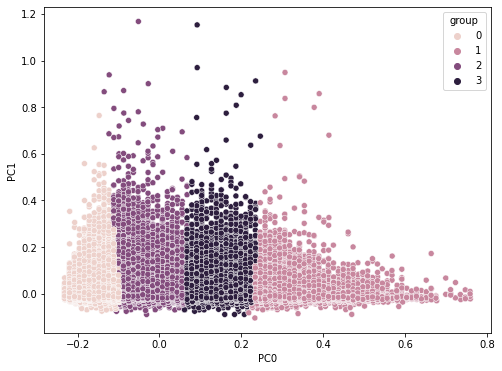

In [19]:
from sklearn.decomposition import MiniBatchSparsePCA

pca = MiniBatchSparsePCA(n_components=2, batch_size=100000, random_state=42)

X_reduced = pca.fit_transform(scaled_train_df)
pca_df = pd.DataFrame(data=X_reduced, columns=[f"PC{i}" for i in range(X_reduced.shape[1])])

pca_results = KMeans(n_clusters=4).fit_predict(X)
pca_df['group'] = pca_results

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="component-0", y="component-1", hue="group")
plt.show()

### References

- https://www.kaggle.com/code/titericz/profiling-pandas-and-cudf
- https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html